In [2]:
from scipy.optimize import minimize

In [3]:
from utils.plotting import *
from utils.helpers import find_bounds, LABELS
from utils.mcmc import *

# Load Data

## Search the light curves

In [4]:
import lightkurve as lk

# Here, you can choose your target :
target_name = "TOI 6894"

search_result = lk.search_lightcurve(target=target_name)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 72,2023,SPOC,120,67512645,0.0
1,TESS Sector 22,2020,TESS-SPOC,1800,67512645,0.0
2,TESS Sector 45,2021,TESS-SPOC,600,67512645,0.0
3,TESS Sector 46,2021,TESS-SPOC,600,67512645,0.0
4,TESS Sector 49,2022,TESS-SPOC,600,67512645,0.0
5,TESS Sector 72,2023,TESS-SPOC,200,67512645,0.0
6,TESS Sector 45,2021,QLP,600,67512645,0.0
7,TESS Sector 49,2022,QLP,600,67512645,0.0
8,TESS Sector 72,2023,QLP,200,67512645,0.0


## Raw Light Curve

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\2137939580.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  lc_plot.show()


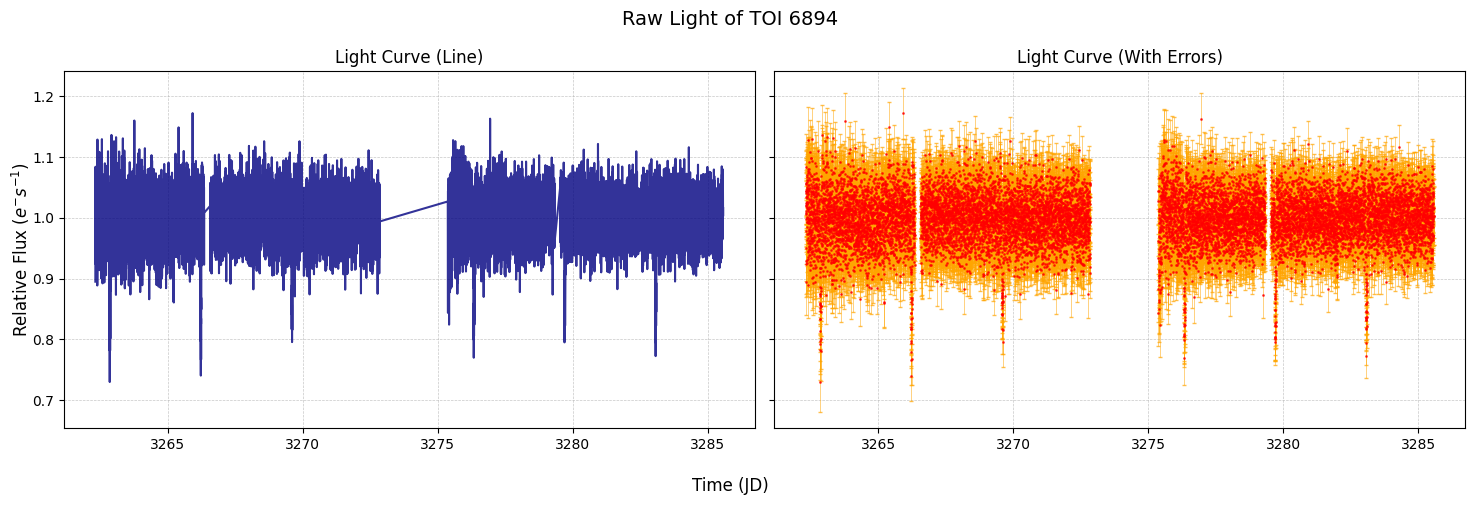

In [5]:
row = 0

lc = search_result[row].download().normalize().remove_nans()
time     = lc.time.value
flux     = lc.flux.value
flux_err = lc.flux_err.value

lc_plot = lightcurve(time, flux, flux_err, target_name, 'Raw')
lc_plot.tight_layout()
lc_plot.show()

## Periodogram

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\2100132109.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pg_plot.show()


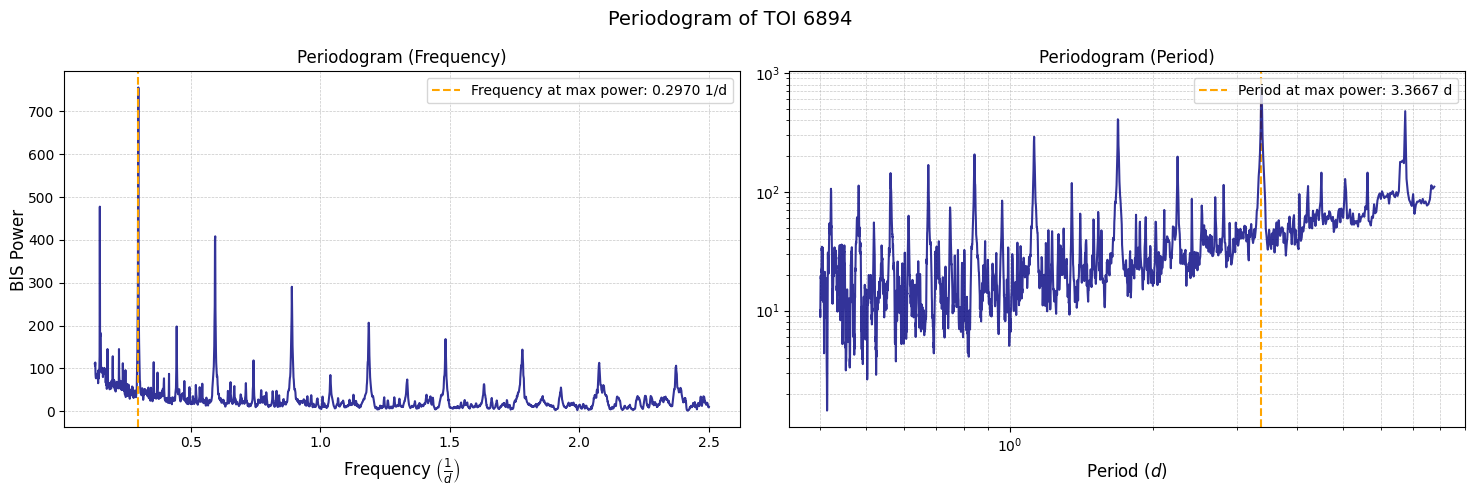

In [6]:
pg = lc.to_periodogram(method='bls', minimum_period=0.4)

freq  = pg.frequency.value
per   = pg.period.value 
power = pg.power.value
max_freq = pg.frequency_at_max_power.value
max_per  = pg.period_at_max_power.value

pg_plot = periodogram(freq, per, power, max_freq, max_per, target_name)
pg_plot.tight_layout()
pg_plot.show()

## Folded Light Curve

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\250211251.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fold_plot.show()


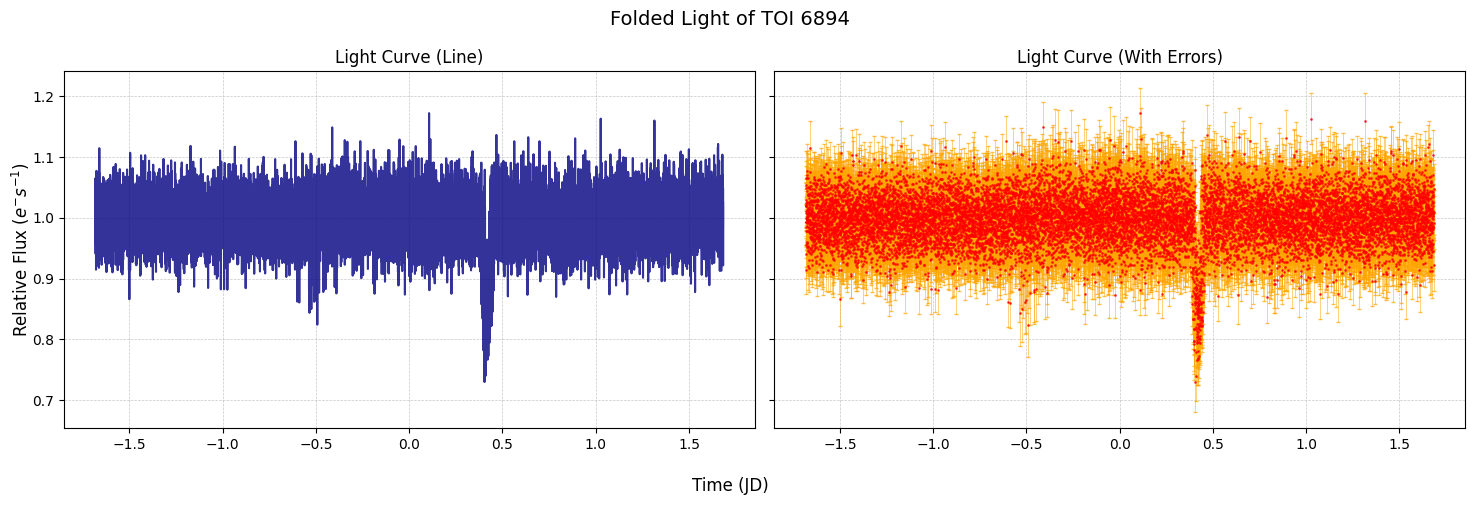

In [17]:
fold = lc.fold(period=max_per, epoch_time=lc.time[0].value, epoch_phase=theta_max[0])

time_fold     = fold.time.value
flux_fold     = fold.flux.value
flux_fold_err = fold.flux_err.value


fold_plot = lightcurve(time_fold, flux_fold, flux_fold_err, target_name, 'Folded')
fold_plot.tight_layout()
fold_plot.show()

# Define and Generate the model

We then need to define the model we are gonna use to run the MCMC simulation. The goal is to define a vector of paramters $\theta$ which will be varying during the simulation.

We use the library `batman`, and we fix the calculation to a *quadratic* darkening model, calculated as such :

$$
I(\mu) = I_0 [1 - c_1(1 - \mu_1) - c_2(1 - \mu)^2], \quad \text{where } \mu = \sqrt{1 - x^2}, 0 \geq x \geq 1 
$$

# Run MCMC

## Setup and initials

In [8]:
# --- PLANET NAME ---
pl_name = "TOI-6894 b"

# ----- BOUNDS ------
BOUNDS = find_bounds(pl_name, 10)
print(BOUNDS)

# ----- WALKERS -----
nwalkers = 46

# ------ STEPS ------
setps = 5000

# ------ INITAL -----
x0 = np.array([(b[0] + b[1]) / 2 for b in BOUNDS])
res = minimize(neg_log_posterior, x0, args=(time, flux, flux_err, BOUNDS), method='POWELL')
if res.success:
    theta_map = res.x
    print("MAP estimate of parameters:", theta_map)
else:
    raise RuntimeError(f"Optimization failed: {res.message}")

# ---- EVOLUTION ----
ndim = len(theta_map)
p0 = [np.array(theta_map) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

# ------- DATA ------
data = (time, flux, flux_err)
data_fold = (time_fold, flux_fold, flux_fold_err)

[(-0.3, 0.3), (np.float64(3.36577196), np.float64(3.37577196)), (np.float64(0.24719710168576373), np.float64(0.5241679461846658)), (np.float64(17.116271064099376), np.float64(32.08788781112031)), (np.float64(87.58), np.float64(91.58)), (0, 1), (0, 1)]
MAP estimate of parameters: [-5.74051827e-02  3.37077197e+00  3.57522244e-01  2.39073759e+01
  8.96127390e+01  4.11859607e-01  5.15623087e-01]


### Run MCMC Simulation

We use the library `emcee` to execute the simulation.

In [ ]:
sampler, pos, prob, state = mcmc(p0, nwalkers, setps, ndim, log_likelihood, data)

Running burn-in...


100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Running production...


100%|██████████| 5000/5000 [06:38<00:00, 12.55it/s]



Mean acceptance fraction: 0.202 (recommended ~0.2–0.5)


In [10]:
chain = sampler.get_chain()
log_prob = sampler.get_log_prob()

np.save("samples.npy", chain)
np.save("log_prob.npy", log_prob)

# chain = np.load("samples.npy")
# log_prob = np.load("log_prob.npy")

samples = chain.reshape(-1, chain.shape[-1])
flat_log_prob = log_prob.reshape(-1)

theta_max = samples[np.argmax(flat_log_prob)]

In [11]:
for i in range(samples.shape[1]):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{LABELS[i]}: {mcmc[1]:.5f} (+{q[1]:.5f}/-{q[0]:.5f})")

$t_0 \, \left( JD \right)$: -0.09091 (+0.19677/-0.18420)
$P \, \left( JD \right)$: 3.37081 (+0.00019/-0.00020)
$R_p \left( \frac{R_p}{R_s} \right)$: 0.40170 (+0.04414/-0.02307)
$a \left( R_s \right)$: 23.72239 (+3.60213/-1.84922)
$I \left( \text{degree} \right)$: 88.68552 (+1.99567/-0.45997)
u1: 0.37929 (+54868589681.69183/-508571033222.16486)
u2: -1.79415 (+557603239322.56775/-59886723771.22088)


### Plotting and Visualize Results

We now present a few different plots to visualize our simulation.

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\718021134.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  model_tryouts.show()


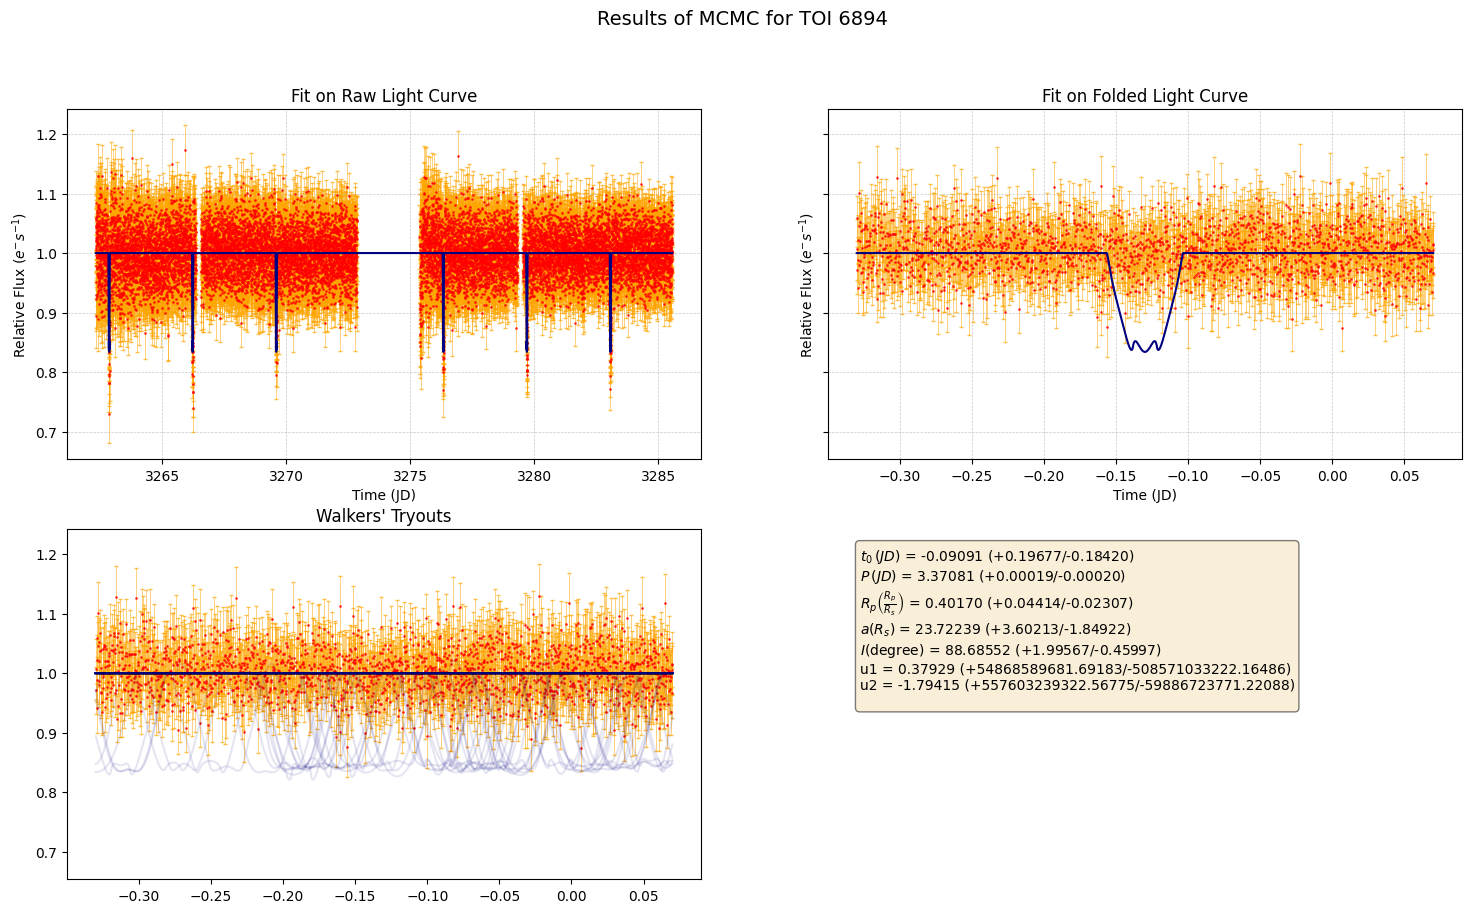

In [12]:
epoch_phase = (lc.time[0].value + (theta_max[0] * max_per)) % max_per

fold = lc.fold(period=max_per, epoch_phase=-0.10)

time_fold     = fold.time.value
flux_fold     = fold.flux.value
flux_fold_err = fold.flux_err.value

model_tryouts = model(time, flux, flux_err, time_fold, flux_fold, flux_fold_err, target_name, samples, flat_log_prob)
model_tryouts.tight_layout
model_tryouts.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\1859204565.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  evolution_plot.show()


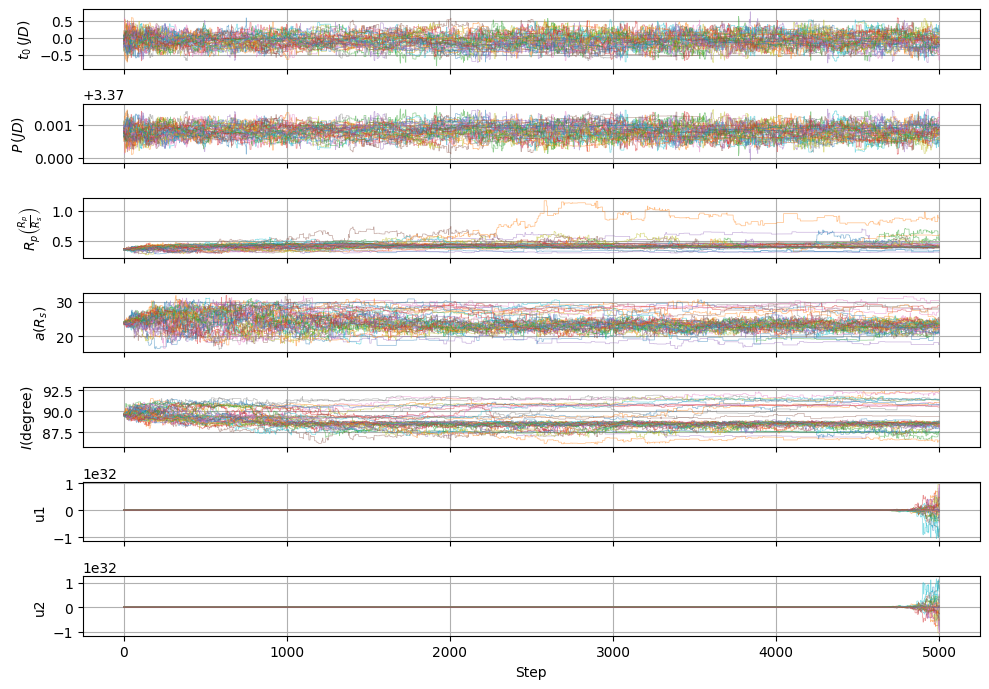

In [13]:
evolution_plot = evolution(chain)
evolution_plot.tight_layout()
evolution_plot.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\2186451352.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_plot.show()


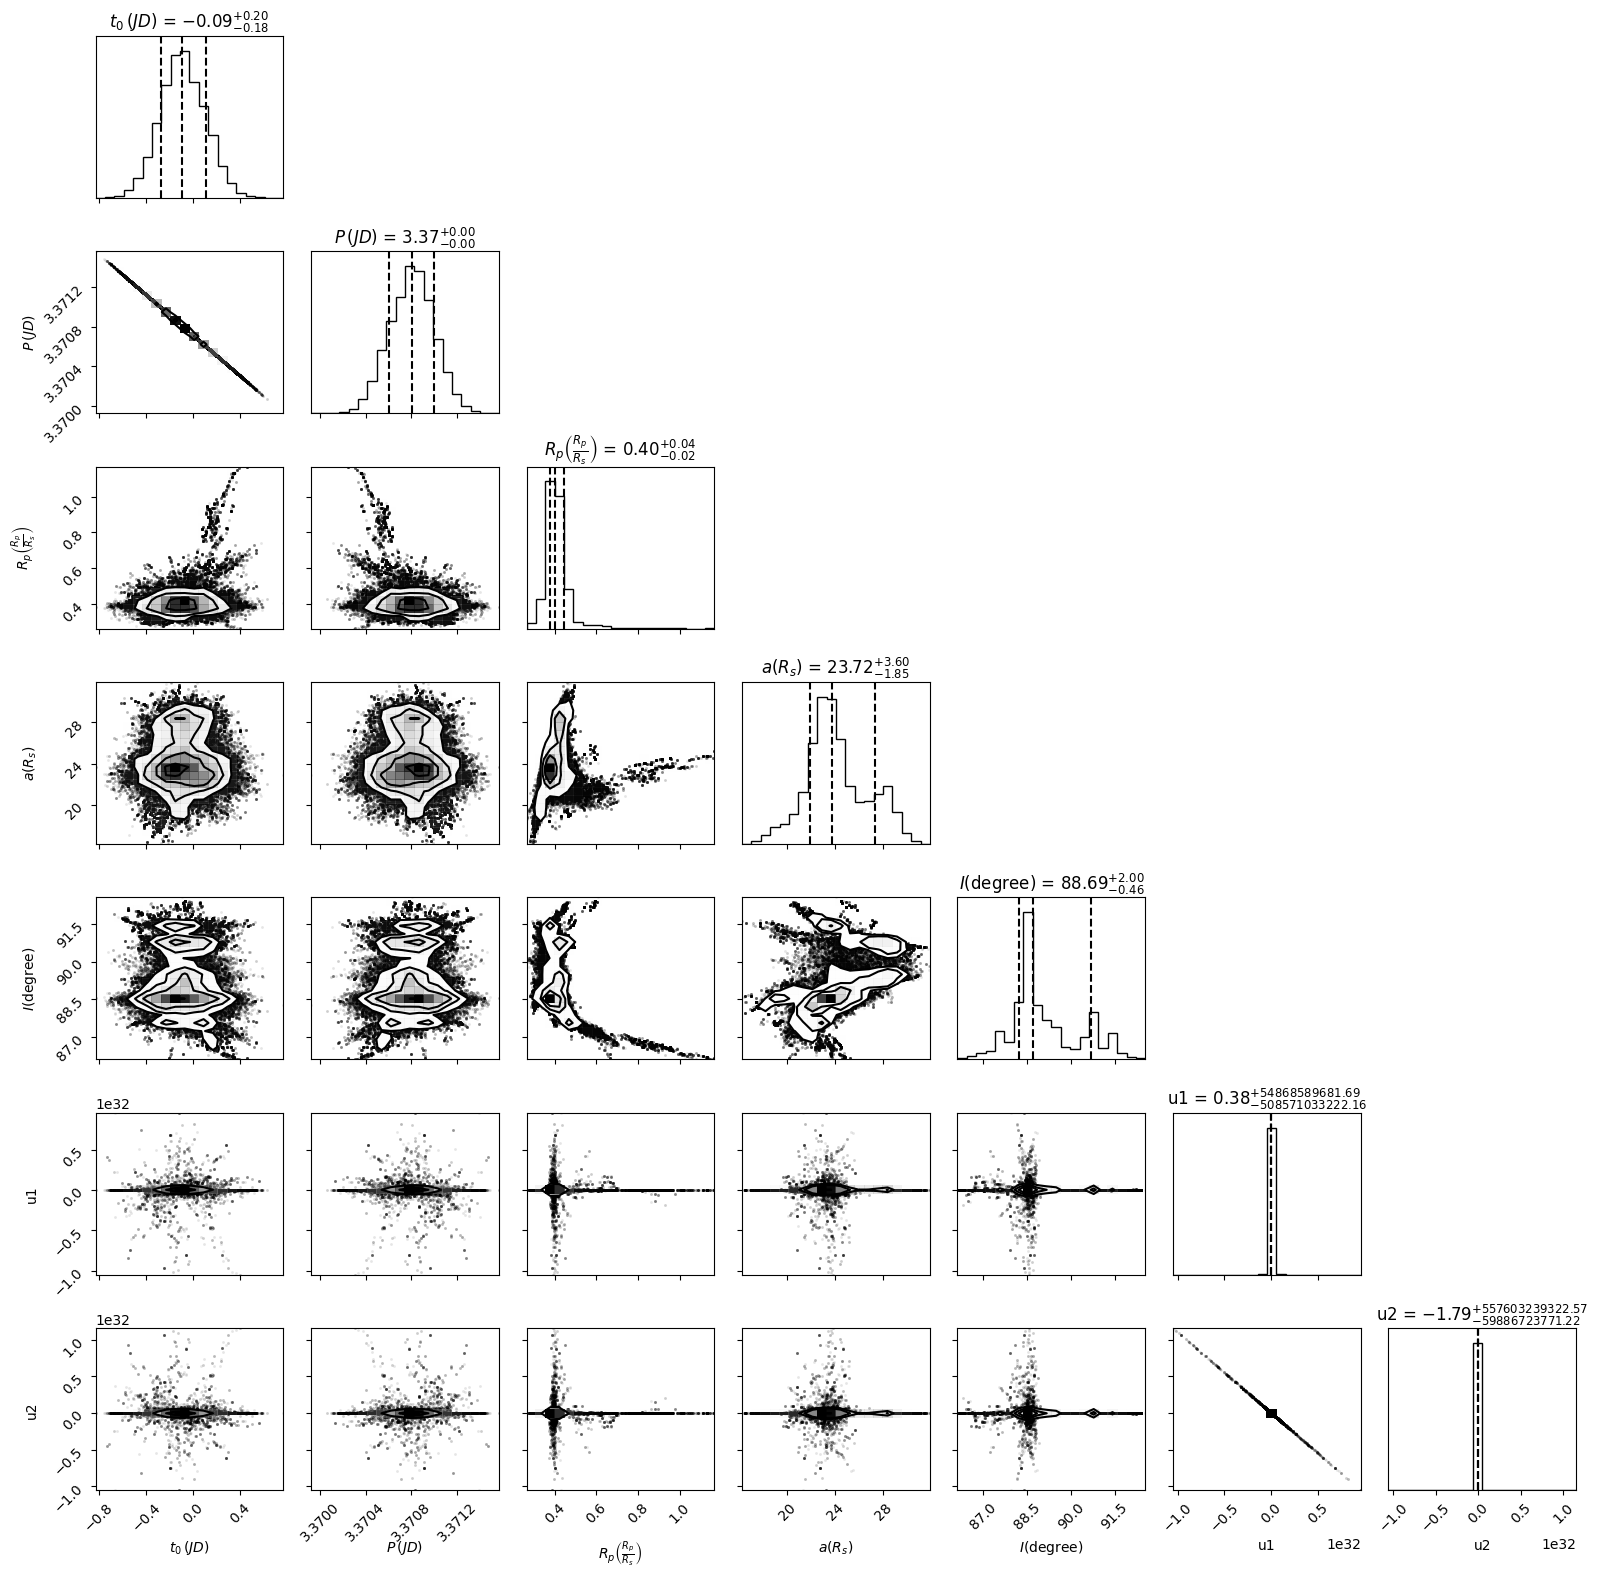

In [14]:
corner_plot = corner_plot(samples)
corner_plot.tight_layout()
corner_plot.show()